In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import os
import matplotlib.pyplot as plt
data_name = 'MouseErythroid'

Global seed set to 0


In [2]:
# Where to get data from and where to save results (you need to modify this)
data_path = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/MouseErythroid/'
results_path = '/nfs/team283/aa16/cell2fate_paper_results/MouseErythroid/'

In [3]:
# # Downloading data into specified directory:
# os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')

Load the data and extract most variable genes (and optionally remove some clusters). We only keep 1000 cells per cluster to speed up the analysis.

In [4]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 1000, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)

Keeping at most 1000 cells per cluster
Filtered out 48345 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


In [5]:
n_modules = 10

Overview of the dataset on a UMAP, coloured by cluster assingment.

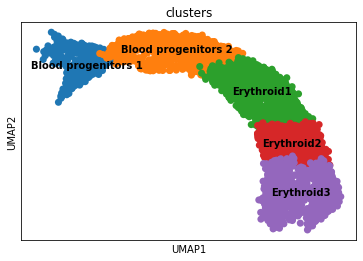

In [6]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')

As usual in the scvi-tools workflow we register the anndata object ...

In [7]:
c2f.Cell2fate_DynamicalModel_SequentialModules_IdentityDependent.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced',
                                           batch_key = 'sequencing.batch')

... and initialize the model:

In [8]:
mod = c2f.Cell2fate_DynamicalModel_SequentialModules_IdentityDependent(adata, n_modules = n_modules)

Let's have a look at the anndata setup:

In [9]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_DynamicalModel_SequentialModules_IdentityDependent.setup_anndata` with 
arguments:

{
│   'layer': None,
│   'batch_key': 'sequencing.batch',
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 4623  │
│      n_vars      │ 3000  │
│     n_batch      │   3   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                        batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sequencing.batch'] │     1      │          0          │
│                               │     2      │          1          │
│                               │     3      │          2          │
└───────────────────────────────┴────────────┴─────────────────────┘

Training the model:

In [10]:
mod.train(use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [10:43<00:00,  1.29s/it, v_num=1, elbo_train=1.65e+7]


We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

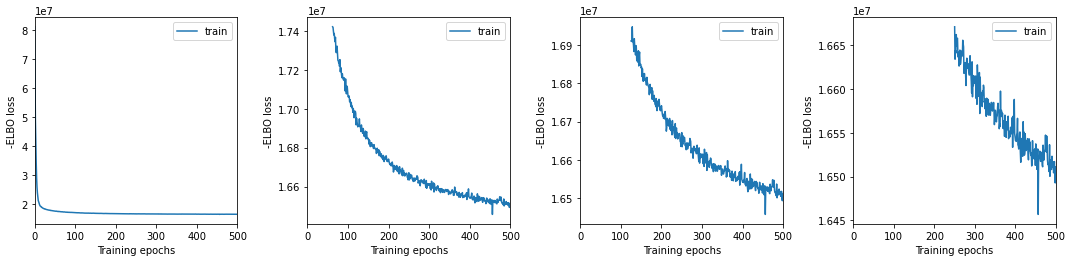

In [11]:
mod.view_history()

Here we export the model posterior to the anndata object:

In [12]:
adata = mod.export_posterior(adata)

sample_kwargs['batch_size'] 4623
Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:

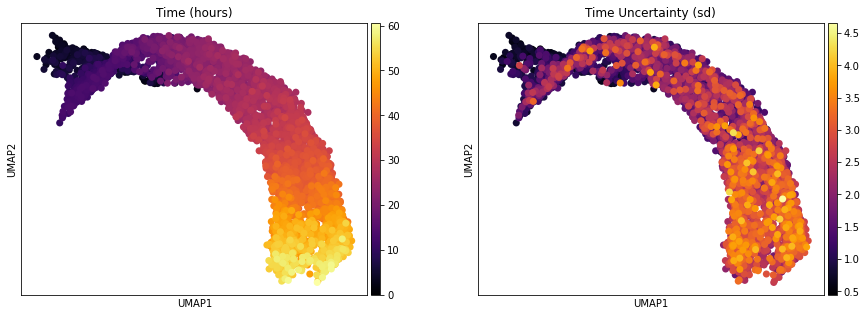

In [13]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])
plt.savefig(results_path + data_name + 'UMAP_Time.pdf')

We can compute some module statistics to visualize the activity of the underlying modules:

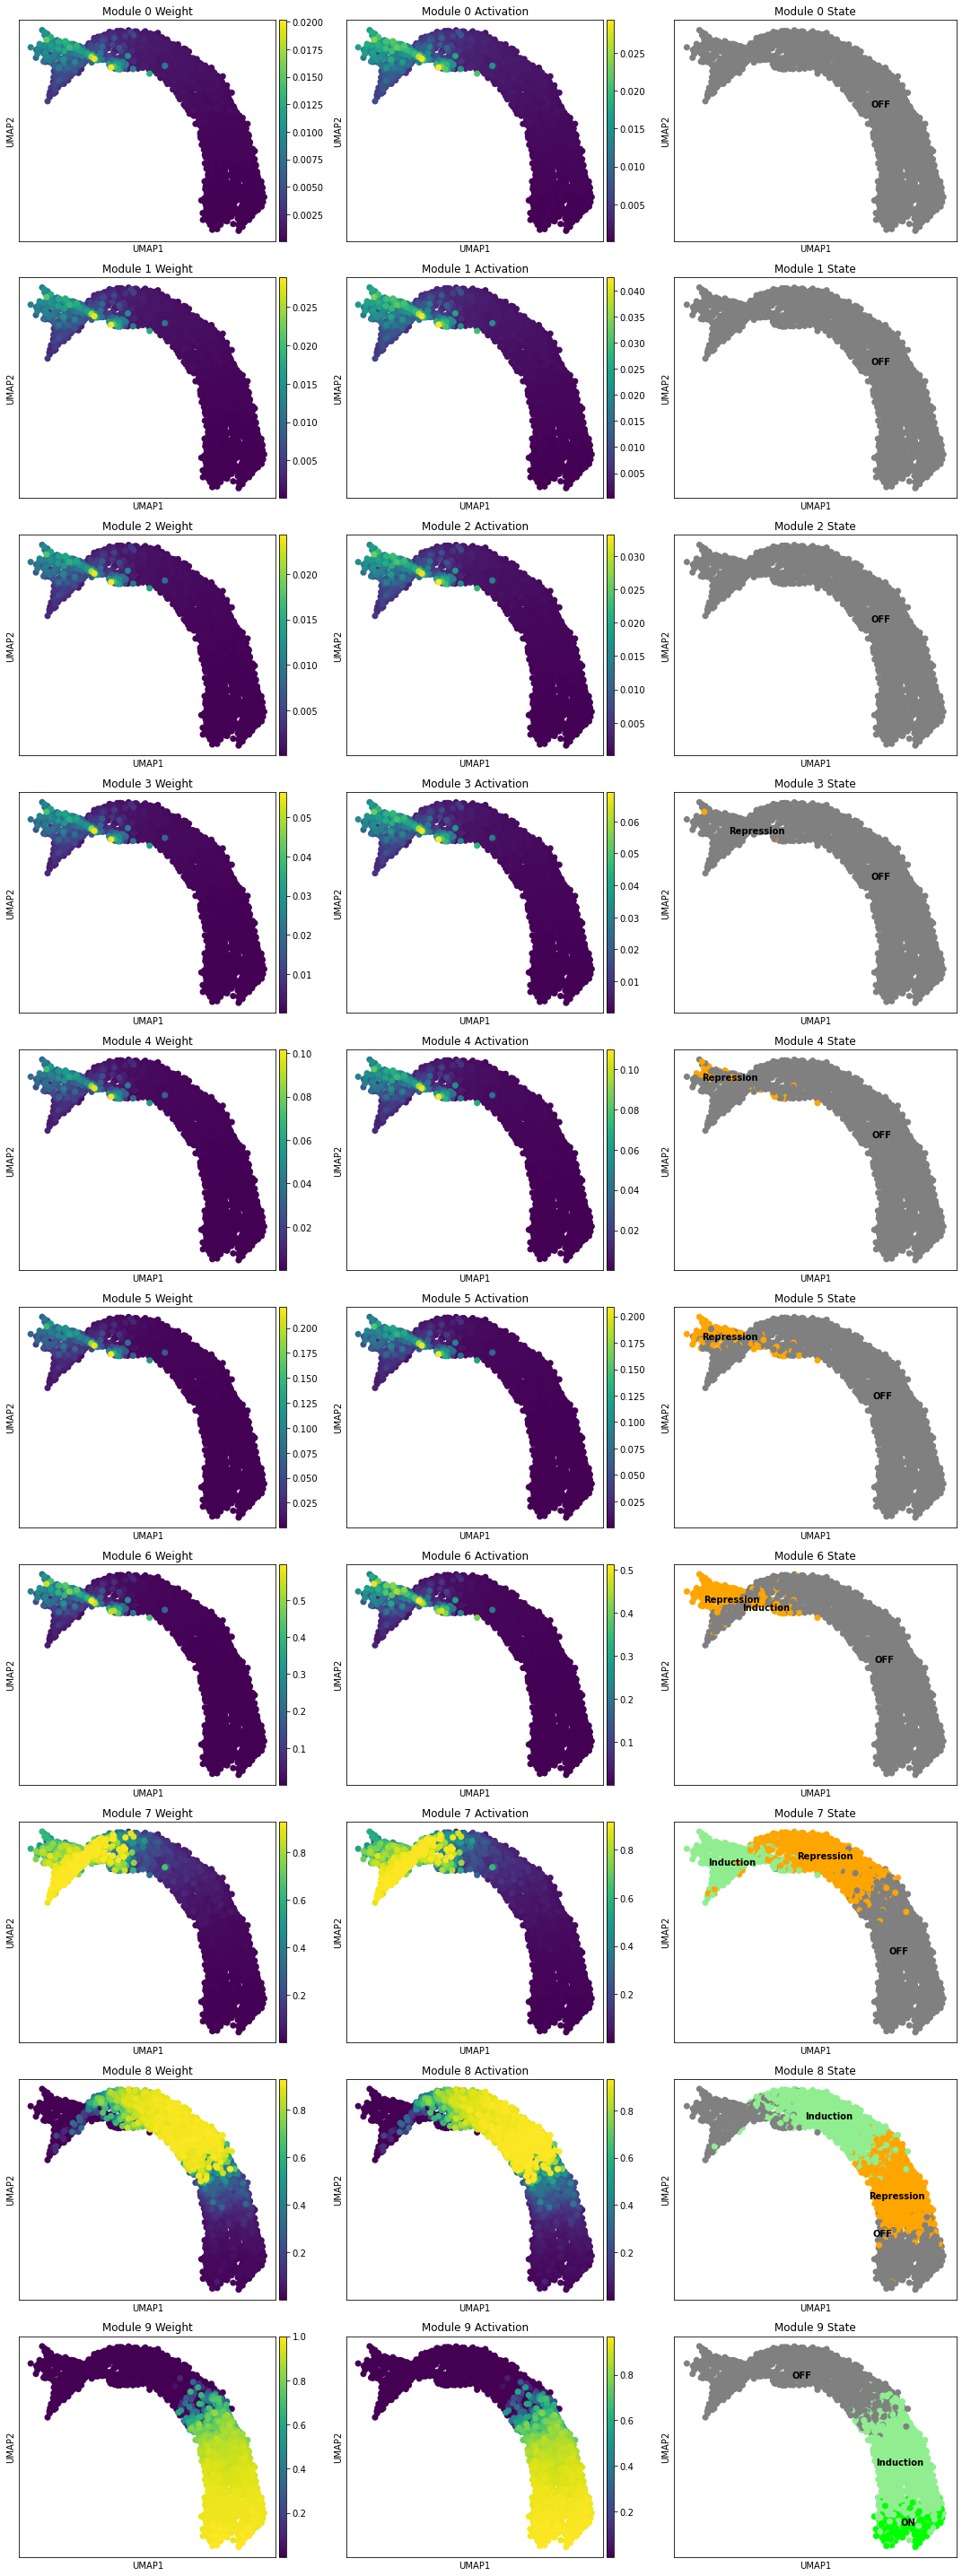

In [14]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata, save = results_path + data_name + 'module_summary_stats_plot.pdf')

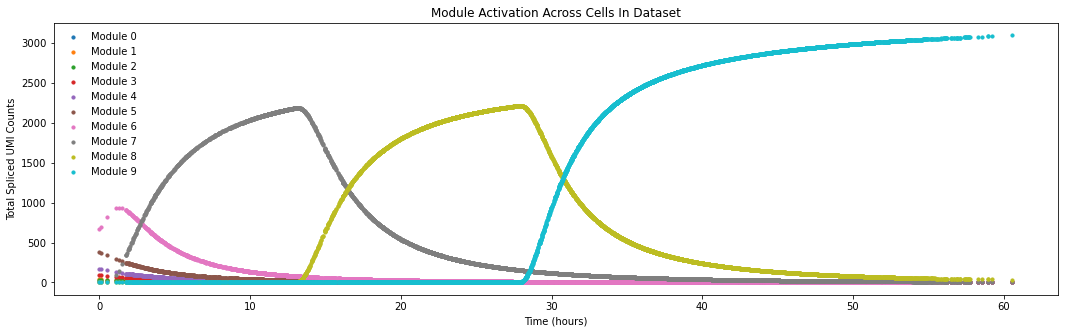

In [28]:
mod.compare_module_activation(adata, chosen_modules = [0,1,2,3,4,5,6,7,8,9],
                         save = results_path + data_name + 'module_activation_comparison.pdf')

And of course we can make the usual visualization of total RNAvelocity on a UMAP:

In [16]:
# mod.compute_and_plot_total_velocity(adata, save = results_path + data_name + 'total_velocity_plots.png')

In [17]:
# import matplotlib.pyplot as plt
# import scvelo as scv
# fix, ax = plt.subplots(1, 1, figsize = (8, 6))
# scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='Velocity',
#                                  show = False, ax = ax, legend_fontsize = 13)
# plt.savefig(results_path + data_name + 'total_velocity_plots.png')

Technical variables usually show lower detection efficiency and higher noise (= lower overdispersion parameter) for unspliced counts:

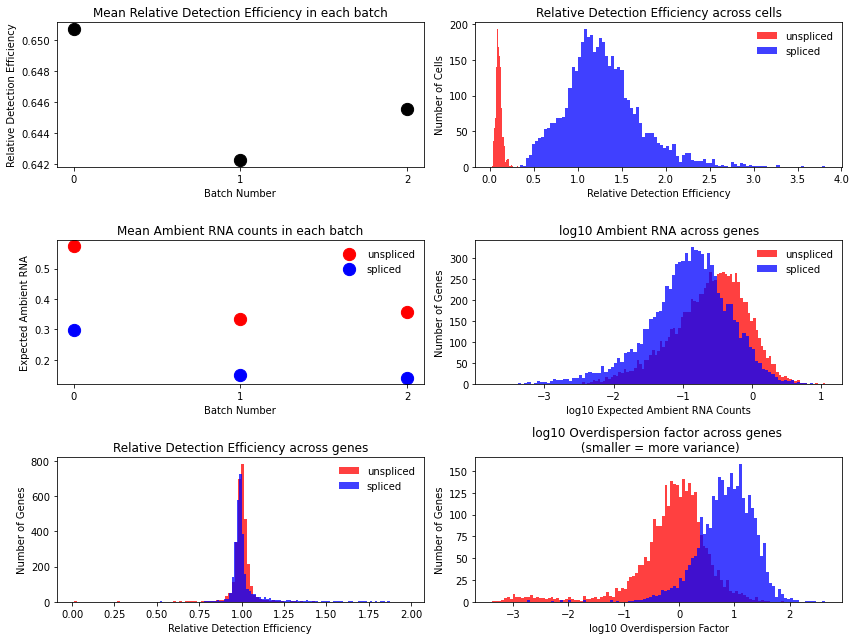

In [18]:
mod.plot_technical_variables(adata, save = results_path + data_name + 'technical_variables_overview_plot.pdf')

This is how to have a look at the various rate parameters the optimization converged to:

In [19]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 0.30407763
gamma_g mean: 0.9356538
beta_g mean: 0.66434044
lam_mi, all modules: 
 
 [[[3.31 3.48]]

 [[3.1  2.47]]

 [[0.46 1.15]]

 [[3.56 3.08]]

 [[2.17 1.79]]

 [[3.99 2.27]]

 [[5.12 2.87]]

 [[5.67 2.8 ]]

 [[4.51 3.12]]

 [[3.7  2.09]]]


This method returns orders the genes and TFs in each module from most to least enriched. And it also performs gene set enrichment analysis:

In [20]:
tab, all_results = mod.get_module_top_features(adata, p_adj_cutoff=0.01, background = adata.var_names)
tab.to_csv(results_path + data_name + 'module_top_features_table.csv')

In [21]:
tab

,Module Number,Genes Ranked,TFs Ranked,Terms Ranked
0,0,"Tmtc2, Large1, Ptprg, Zfp521, Fer, Med12l, Fbx...","Zfp521, Zfp141, Taf1, Mxi1, L3mbtl3, Zfp608, Z...",
1,1,"Tmtc2, Large1, Zfp521, Ptprg, Med12l, Fer, Arh...","Zfp521, Zfp608, Hmbox1, Zfp141, Zfp592, Prdm2,...",
2,2,"Large1, Zfp521, Med12l, Zyx, Arhgap6, Tmtc2, F...","Zfp521, Zfp141, Zfp592, Zfp608, Prdm2, Mxi1, H...",
3,3,"Zyx, Arhgap6, Zfp608, Med12l, Zfp521, Fbxl17, ...","Zfp608, Zfp521, Hmbox1, Zfp143, Meis1, Zfp141,...",
4,4,"B2m, Srgap1, Gzmg, Spp1, Pip4k2a, Zfp608, Pde5...","Zfp608, Meis1, Hmbox1, Mef2c, Elk3, Plek, Zfp1...",regulation of small GTPase mediated signal tra...
5,5,"B2m, Mef2c, Nkg7, Gimap6, Itgb3, Fxyd5, Gzmg, ...","Mef2c, Meis1, Elk3, Plek, Erg, Zfp608, Mef2a, ...",regulation of small GTPase mediated signal tra...
6,6,"Cd34, Igf1, Arhgap18, Gimap6, Pla2g4a, Rasgrp3...","Erg, Elk3, Plek, Mef2c, Meis1, Mef2a, Tet3, Me...",regulation of small GTPase mediated signal tra...
7,7,"Man2c1, Id3, Lgr5, Vcan, Dab1, Rit1, Rspo3, Ga...","Id3, Gata2, Smad6, Tcf7l2, Lrrfip1, Bmp2, Zfhx...",positive regulation of osteoblast differentiat...
8,8,"Man2c1, Fam168a, Gm15915, Fubp3, Ammecr1, Rbm1...","Fubp3, Phtf2, Khsrp, Zfp385a, Esrra, Zbtb46, F...",
9,9,"Gpr108, Pold1, Parpbp, Etaa1, Ckap2, Kif18a, S...","Ikzf5, Arid3a, Mllt3, Lrrfip2, Klf3, Elf1, Run...",


Plot transcription rate for MURK genes:

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
def mu_alpha(alpha_new, alpha_old, tau, lam):
    '''Calculates transcription rate as a function of new target transcription rate,
    old transcription rate at changepoint, time since change point and rate of exponential change process'''
    return (alpha_new - alpha_old) * (1 - torch.exp(-lam*tau)) + alpha_old

def mu_mRNA_continuousAlpha_withPlates(alpha, beta, gamma, tau, u0, s0, delta_alpha, lam):
    ''' Calculates expected value of spliced and unspliced counts as a function of rates, latent time, initial states,
    difference to transcription rate in previous state and rate of exponential change process between states.'''
    
    mu_u = u0*torch.exp(-beta*tau) + (alpha/beta)* (1 - torch.exp(-beta*tau)) + delta_alpha/(beta-lam+10**(-5))*(torch.exp(-beta*tau) - torch.exp(-lam*tau))
    mu_s = (s0*torch.exp(-gamma*tau) + 
    alpha/gamma * (1 - torch.exp(-gamma*tau)) +
    (alpha - beta * u0)/(gamma - beta+10**(-5)) * (torch.exp(-gamma*tau) - torch.exp(-beta*tau)) +
    (delta_alpha*beta)/((beta - lam+10**(-5))*(gamma - beta+10**(-5))) * (torch.exp(-beta*tau) - torch.exp(-gamma*tau))-
    (delta_alpha*beta)/((beta - lam+10**(-5))*(gamma - lam+10**(-5))) * (torch.exp(-lam*tau) - torch.exp(-gamma*tau)))

    return torch.stack([mu_u, mu_s], axis = -1)

def mu_mRNA_continousAlpha_globalTime_twoStates(alpha_ON, alpha_OFF, beta, gamma, lam_gi, T_c, T_gON, T_gOFF, Zeros):
    '''Calculates expected value of spliced and unspliced counts as a function of rates,
    global latent time, initial states and global switch times between two states'''
    n_cells = T_c.shape[-2]
    n_genes = alpha_ON.shape[-1]
    tau = torch.clip(T_c - T_gON, min = 10**(-5))
    t0 = T_gOFF - T_gON
    # Transcription rate in each cell for each gene:
    boolean = (tau < t0).reshape(n_cells, 1)
    alpha_cg = alpha_ON*boolean + alpha_OFF*~boolean
    # Time since changepoint for each cell and gene:
    tau_cg = tau*boolean + (tau - t0)*~boolean
    # Initial condition for each cell and gene:
    lam_g = ~boolean*lam_gi[:,1] + boolean*lam_gi[:,0]
    initial_state = mu_mRNA_continuousAlpha_withPlates(alpha_ON, beta, gamma, t0,
                                                       Zeros, Zeros, alpha_ON-alpha_OFF, lam_gi[:,0])
    initial_alpha = mu_alpha(alpha_ON, alpha_OFF, t0, lam_gi[:,0])
    u0_g = 10**(-5) + ~boolean*initial_state[:,:,0]
    s0_g = 10**(-5) + ~boolean*initial_state[:,:,1]
    delta_alpha = ~boolean*initial_alpha*(-1) + boolean*alpha_ON*(1)
    alpha_0 = alpha_OFF + ~boolean*initial_alpha
    # Unspliced and spliced count variance for each gene in each cell:
    mu_RNAvelocity = torch.clip(mu_mRNA_continuousAlpha_withPlates(alpha_cg, beta, gamma, tau_cg,
                                                         u0_g, s0_g, delta_alpha, lam_g), min = 10**(-5))
    alpha_0 = alpha_OFF + ~boolean*initial_alpha
    alpha_cg = mu_alpha(alpha_cg, alpha_0, tau_cg, lam_g)
    return mu_RNAvelocity, alpha_cg

In [23]:
n_cells = len(adata.obs_names)
n_vars = len(adata.var_names)

In [24]:
mu_m = []
alpha_cg = []

for m in range(n_modules):
    print(m)
    mu, alpha, = mu_mRNA_continousAlpha_globalTime_twoStates(
                torch.tensor(mod.samples['post_sample_means']['A_mgON'][m,:]),
                torch.tensor(0., dtype = torch.float),
                torch.tensor(mod.samples['post_sample_means']['beta_g']),
                torch.tensor(mod.samples['post_sample_means']['gamma_g']),
                torch.tensor(mod.samples['post_sample_means']['lam_mi'][m,...]),
                torch.tensor(mod.samples['post_sample_means']['T_c'][...,0]),
                torch.tensor(mod.samples['post_sample_means']['T_mON'][...,m]),
                torch.tensor(mod.samples['post_sample_means']['T_mOFF'][...,m]),
                torch.zeros((n_cells, n_vars)))
    mu_m += [m]
    alpha_cg += [alpha]
alpha = np.stack(alpha_cg, axis = 0)

0
1
2
3
4
5
6
7
8
9


In [25]:
MURK_genes = ['Hba-x', 'Smim1', 'Dcxr', 'Cox6b2', 'Gypa', 'Cpox', 'Hbb-bh1', 'Nudt4', 'Hbb-bt']

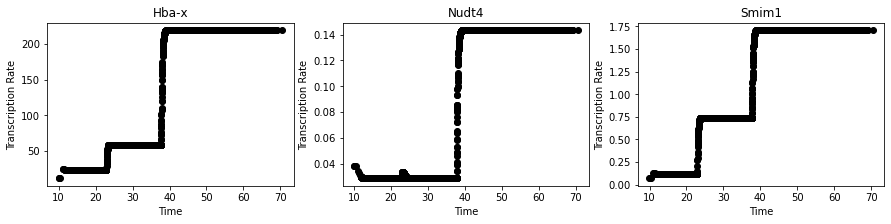

In [26]:
fig, ax = plt.subplots(1,3,figsize = (15, 3))
count = 0
for g in [0,7,1]:
    ax[count].scatter(mod.samples['post_sample_means']['T_c'][:,0,0], 
                np.sum(alpha_cg, axis = 0)[:, np.where(adata.var_names == MURK_genes[g])[0][0]],
               c = 'black')
    ax[count].set_title(MURK_genes[g])
    ax[count].set_xlabel('Time')
    ax[count].set_ylabel('Transcription Rate')
    count += 1
plt.savefig(results_path + data_name + 'MURK_geneTranscription_rate.pdf', bbox_inches="tight")